## Reward-effort task simulations

In [310]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Simulating participants

In [327]:
# Trial numbers (40 mins, 6s per trial, 400 total trials)
num_trials = 400
num_blocks = 8 # 2 action type x 2 global effort state x 2 attentional focus
num_trials_per_block = num_blocks / num_blocks

# Reward and effort levels
outcome_levels_n = np.linspace(-10, 10, 11) 
outcome_levels = outcome_levels_n[outcome_levels_n != 0] # remove 0
effort_levels = np.linspace(5, 10, 11) 


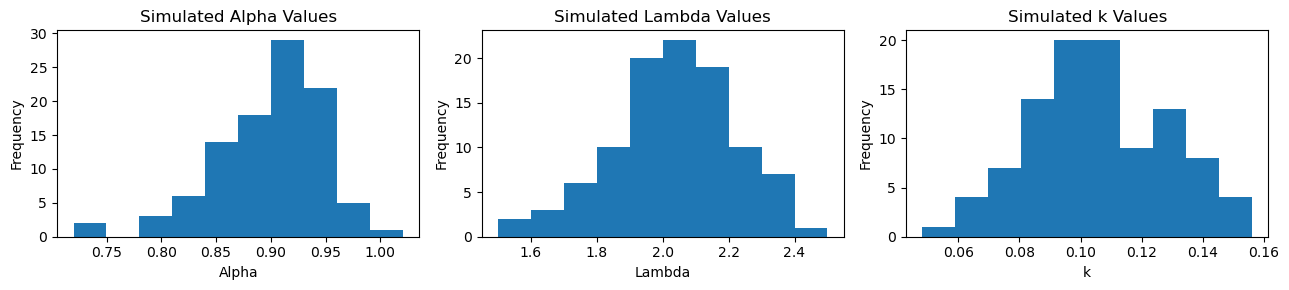

In [328]:
# Simulate participants with different sensitivities - get realistic values from the literature
num_participants = 100

# Specify mean and sd of parameters
alpha_mean, alpha_std = 0.9, 0.05
lambda_mean, lambda_std = 2.0, 0.2
k_mean, k_std = 0.11, 0.02

# Generate parameters from normal distributions
alpha_values = np.random.normal(alpha_mean, alpha_std, num_participants)
lambda_values = np.random.normal(lambda_mean, lambda_std, num_participants)
k_values = np.random.normal(k_mean, k_std, num_participants)

# Ensure parameters are within a reasonable range
alpha_values = np.clip(alpha_values, 0.7, 1.2)
lambda_values = np.clip(lambda_values, 1.5, 2.5)
k_values = np.clip(k_values, 0, 1)


# Plot histograms of the parameters
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 3))

axes[0].hist(alpha_values)
axes[0].set_title('Simulated Alpha Values')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Frequency')

axes[1].hist(lambda_values)
axes[1].set_title('Simulated Lambda Values')
axes[1].set_xlabel('Lambda')
axes[1].set_ylabel('Frequency')

axes[2].hist(k_values)
axes[2].set_title('Simulated k Values')
axes[2].set_xlabel('k')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

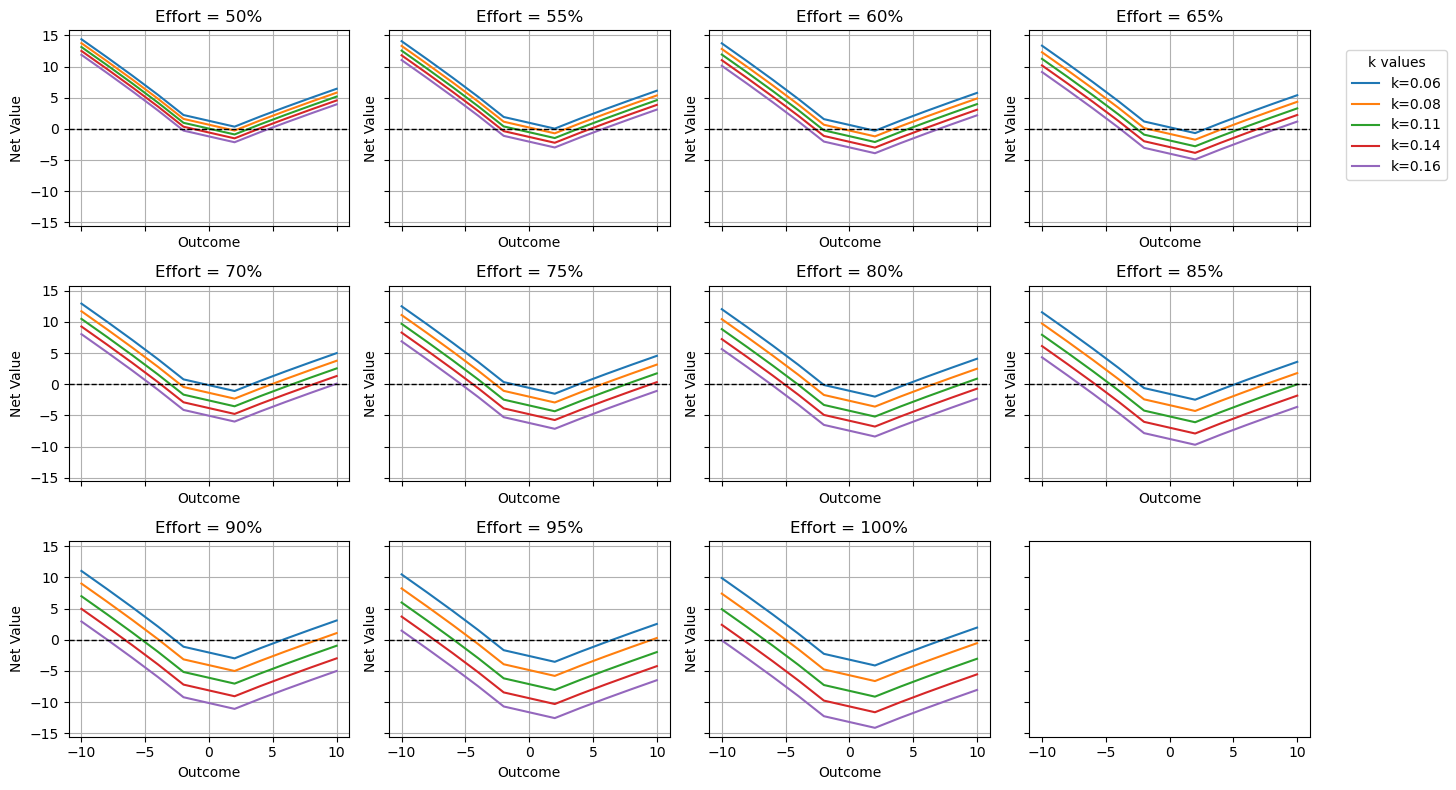

In [329]:
# Function to calculate net value based on outcome, effort, reward sensitivity alpha, loss sensitivty beta, effort sensitivity k, and loss aversion lambda
def calculate_net_value(outcome, effort, alpha, k, lambda_):
    if outcome >= 0:
        return (outcome ** alpha) - k * (effort ** 2)  # positive outcome - effort --> the higher the better
    else:
        return abs(-lambda_ * ((-outcome) ** alpha)) - k * (effort ** 2)  # removing the negative sign from the outcome to get magnitude of (negative) outcome - magnitude of effort --> the higher the less bad (ie better)



# Plot the net value function for different ks at different effort levels, fixing alpha and lambda at their mean values
plot_ks = np.linspace(0.06, 0.16, 5)  # different values for k
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.flatten()
for i, plot_effort in enumerate(effort_levels):
    ax = axes[i]
    for plot_k in plot_ks:
        net_values = [calculate_net_value(outcome, plot_effort, alpha_mean, plot_k, lambda_mean) for outcome in outcome_levels]
        ax.plot(outcome_levels, net_values, label=f'k={plot_k:.2f}')
    ax.set_title(f'Effort = {(plot_effort*10).astype(int)}%')
    ax.set_xlabel('Outcome')
    ax.set_ylabel('Net Value')
    ax.axhline(0, color='black', lw=1, linestyle='--')
    ax.grid(True)
    if i == 0: 
        fig.legend(loc='center left', bbox_to_anchor=(0.96, 0.85), title="k values")
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

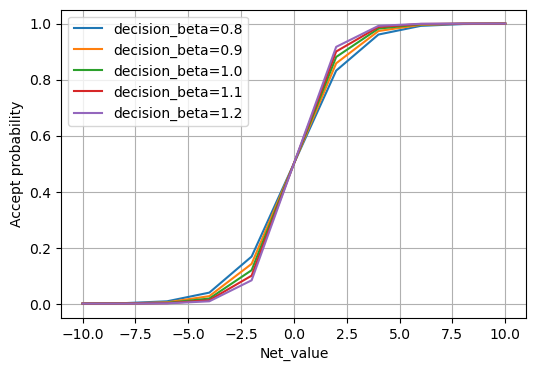

In [330]:
# Logistic function to get choice probabilities
decision_beta = 1  
def logistic_choice_prob(net_value, decision_beta):
    return 1 / (1 + np.exp(-decision_beta * net_value))


# Plot the Logistic function for different betas
plot_betas = np.linspace(0.8, 1.2, 5)
plt.figure(figsize=(6, 4))
for b in plot_betas:
    plt.plot(outcome_levels_n, logistic_choice_prob(outcome_levels_n, b), label=f'decision_beta={b:.1f}')
plt.xlabel('Net_value')
plt.ylabel('Accept probability')
plt.legend()
plt.grid(True)
plt.show()

In [331]:
# Generate stimuli and responses
stimuli = []
responses = []

for outcome in outcome_levels:
    for effort in effort_levels:
        # Calculate net values for all participants
        net_values = np.array([calculate_net_value(outcome, effort, alpha, k, lambda_)
                               for alpha, k, lambda_ in zip(alpha_values, k_values, lambda_values)])
        
        # Apply logistic function to calculate acceptance probabilities
        probabilities = logistic_choice_prob(net_values, decision_beta)
        
        # Simulate binary choices (accept/reject) based on probabilities
        choices = np.random.binomial(1, probabilities)
        
        # Store stimuli and responses
        stimuli.append((outcome, effort))
        responses.append(choices)

# Convert responses to numpy array
responses = np.array(responses)



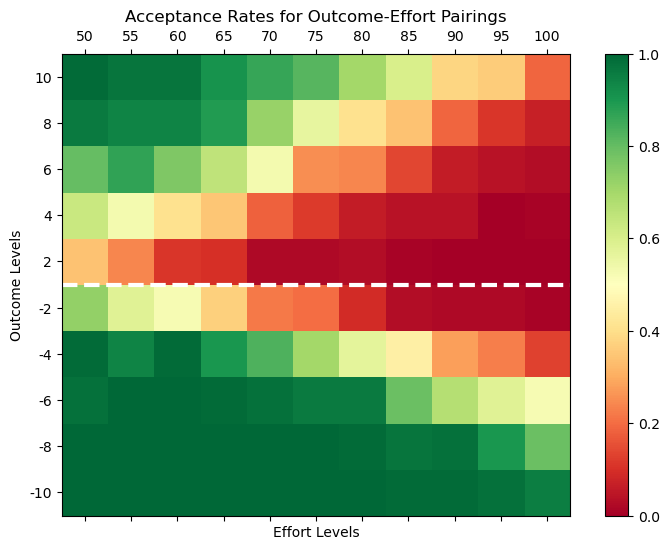

In [332]:
# Visualizing the acceptance rates for each reward-effort pairing across all participants
# Matrix looks asymmetric because of loss aversion
acceptance_rates = responses.mean(axis=1)

# Reshape acceptance rates for plotting 
# acceptance_rates is a 1D array representing the mean acceptance rates across all participants for each reward-effort pairing
# reshaped acceptance_matrix is a 2D array where rows represent different outcome levels and columns represent different effort levels
acceptance_matrix = acceptance_rates.reshape(len(outcome_levels), len(effort_levels))

fig, ax = plt.subplots(figsize=(9, 6))
cax = ax.matshow(acceptance_matrix, interpolation='nearest', cmap='RdYlGn')
fig.colorbar(cax)

ax.set_xticks(np.arange(len(effort_levels)))
ax.set_yticks(np.arange(len(outcome_levels)))
ax.set_xticklabels((effort_levels*10).astype(int))
ax.set_yticklabels(outcome_levels.astype(int))
ax.invert_yaxis()
lowest_reward_index = np.where(outcome_levels == 2)[0][0]
ax.axhline(lowest_reward_index - 0.5, color='white', linestyle='--', linewidth=3)

plt.xlabel('Effort Levels')
plt.ylabel('Outcome Levels')
plt.title('Acceptance Rates for Outcome-Effort Pairings')
plt.show()


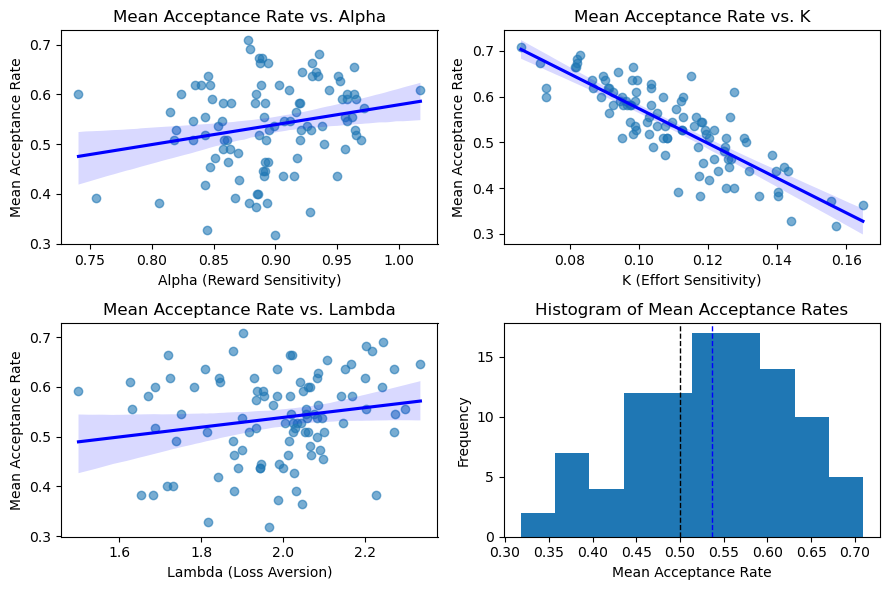

In [317]:
# Calculate mean acceptance rates
mean_acceptance_rates = responses.mean(axis=0)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 6))

# Plot for Alpha vs. Mean Acceptance Rate
sns.regplot(x=alpha_values, y=mean_acceptance_rates, ax=axs[0, 0], scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
axs[0, 0].set_xlabel('Alpha (Reward Sensitivity)')
axs[0, 0].set_ylabel('Mean Acceptance Rate')
axs[0, 0].set_title('Mean Acceptance Rate vs. Alpha')

# Plot for K vs. Mean Acceptance Rate
sns.regplot(x=k_values, y=mean_acceptance_rates, ax=axs[0, 1], scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
axs[0, 1].set_xlabel('K (Effort Sensitivity)')
axs[0, 1].set_ylabel('Mean Acceptance Rate')
axs[0, 1].set_title('Mean Acceptance Rate vs. K')

# Plot for Lambda vs. Mean Acceptance Rate
sns.regplot(x=lambda_values, y=mean_acceptance_rates, ax=axs[1, 0], scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
axs[1, 0].set_xlabel('Lambda (Loss Aversion)')
axs[1, 0].set_ylabel('Mean Acceptance Rate')
axs[1, 0].set_title('Mean Acceptance Rate vs. Lambda')

# Plot histogram of mean acceptance rates
axs[1, 1].hist(mean_acceptance_rates)
axs[1, 1].set_xlabel('Mean Acceptance Rate')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Histogram of Mean Acceptance Rates')
axs[1, 1].axvline(0.5, color='black', lw=1, linestyle='--')
axs[1, 1].axvline(np.mean(mean_acceptance_rates), color='blue', lw=1, linestyle='--')

plt.tight_layout()
plt.show()

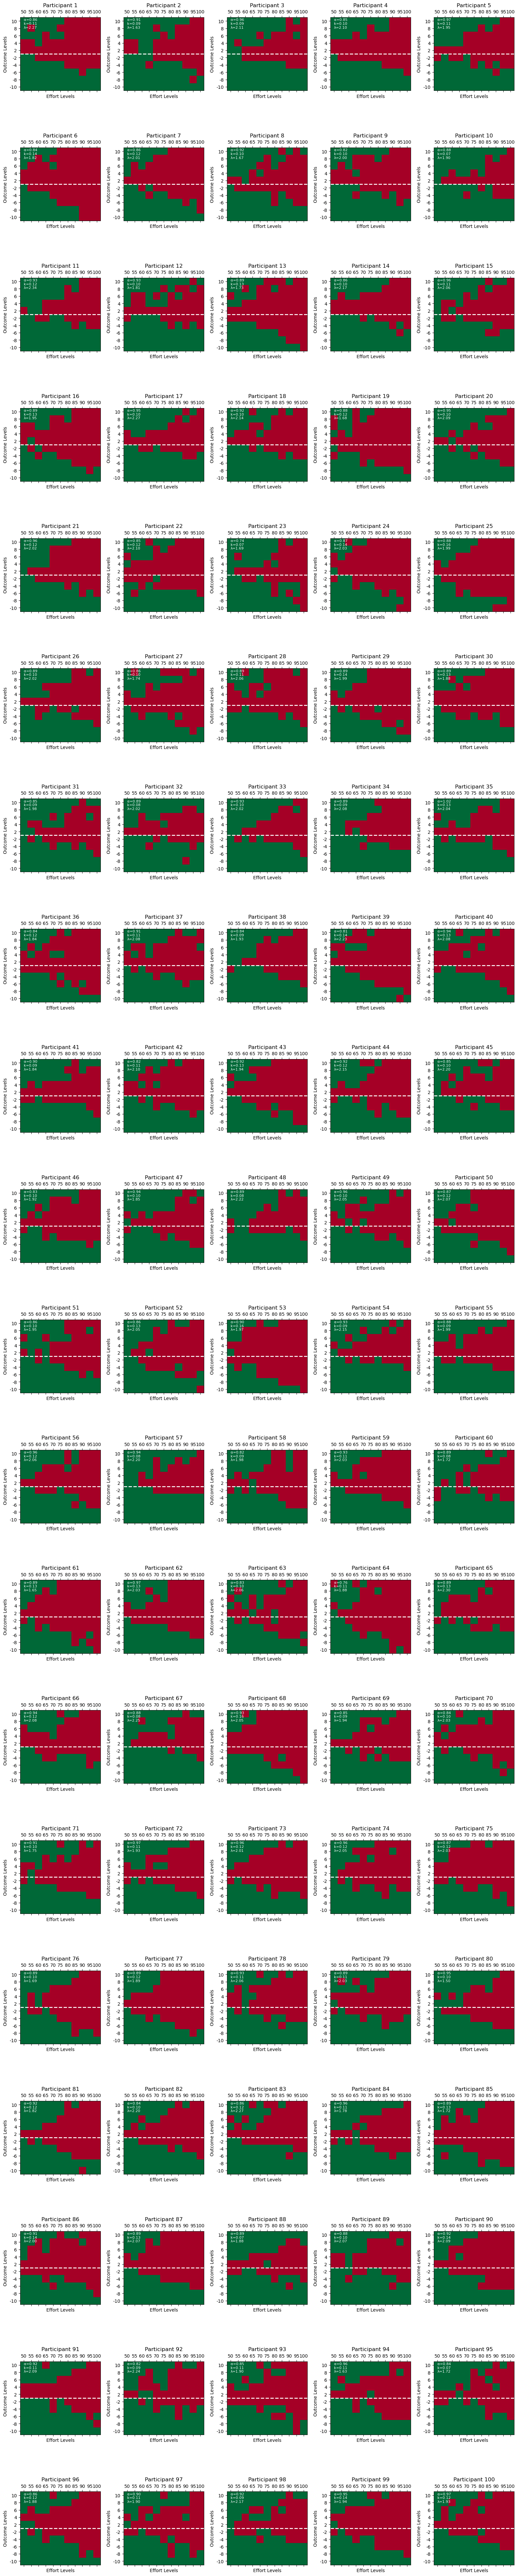

In [318]:
# Visualizing the acceptance rates for each participant separately
num_cols = 5 
num_rows = num_participants // num_cols + (1 if num_participants % num_cols else 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))

for participant_idx in range(num_participants):
    row = participant_idx // num_cols
    col = participant_idx % num_cols
    
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    participant_responses = responses[:, participant_idx]
    participant_acceptance_matrix = participant_responses.reshape(len(outcome_levels), len(effort_levels))
    
    cax = ax.matshow(participant_acceptance_matrix, interpolation='nearest', cmap='RdYlGn')
    
    ax.set_xticks(np.arange(len(effort_levels)))
    ax.set_yticks(np.arange(len(outcome_levels)))
    ax.set_xticklabels((effort_levels*10).astype(int))
    ax.set_yticklabels(outcome_levels.astype(int))
    ax.invert_yaxis()
    lowest_reward_index = np.where(outcome_levels == 2)[0][0]
    ax.axhline(lowest_reward_index - 0.5, color='white', linestyle='--', linewidth=2)
    
    ax.set_xlabel('Effort Levels')
    ax.set_ylabel('Outcome Levels')
    ax.set_title(f'Participant {participant_idx + 1}')

    # Print participant parameters 
    params_text = (f"α={alpha_values[participant_idx]:.2f} \n"
                   f"k={k_values[participant_idx]:.2f} \n"
                   f"λ={lambda_values[participant_idx]:.2f}")
    ax.text(0, len(outcome_levels) - 2, params_text, color='white', fontsize=8)

plt.tight_layout()
plt.show()

### Selecting task stimuli

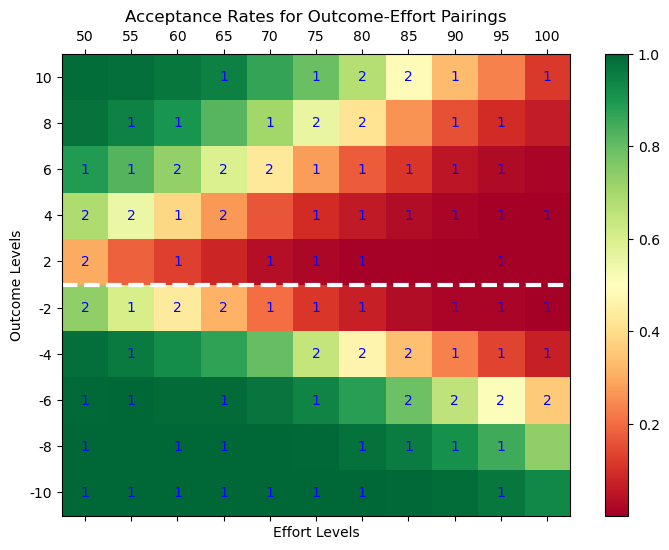

In [453]:
# Define the number of trials and structure for the experiment
num_trials = 400  # Total number of trials
num_blocks = 8  # Number of blocks, each block represents a unique condition combination
num_trials_per_block = int(num_trials / num_blocks)  # Trials per block

# Define reward and effort levels
outcome_levels_n = np.linspace(-10, 10, 11)  # Reward levels ranging from -10 to 10
outcome_levels = outcome_levels_n[outcome_levels_n != 0]  # Remove 0 from reward levels
effort_levels = np.linspace(5, 10, 11)  # Effort levels ranging from 5 to 10

# Simulate participants with different sensitivities based on literature values
num_participants = 1000  # Number of participants to simulate
# Mean and standard deviation of sensitivity parameters
alpha_mean, alpha_std = 0.9, 0.05  # Reward sensitivity parameters
lambda_mean, lambda_std = 2.0, 0.2  # Loss aversion parameters
k_mean, k_std = 0.11, 0.02  # Effort sensitivity parameters

# Generate sensitivity parameters for each participant from normal distributions
alpha_values = np.random.normal(alpha_mean, alpha_std, num_participants)
lambda_values = np.random.normal(lambda_mean, lambda_std, num_participants)
k_values = np.random.normal(k_mean, k_std, num_participants)

# Ensure parameters are within reasonable bounds
alpha_values = np.clip(alpha_values, 0.7, 1.2)
lambda_values = np.clip(lambda_values, 1.5, 2.5)
k_values = np.clip(k_values, 0, 1)

# Function to calculate net value based on outcome, effort, and sensitivity parameters
def calculate_net_value(outcome, effort, alpha, k, lambda_):
    if outcome >= 0:
        return (outcome ** alpha) - k * (effort ** 2)  # For positive outcomes
    else:
        return abs(-lambda_ * ((-outcome) ** alpha)) - k * (effort ** 2)  # For negative outcomes

# Logistic function to convert net value to choice probabilities
decision_beta = 1  
def logistic_choice_prob(net_value, decision_beta):
    return 1 / (1 + np.exp(-decision_beta * net_value))

# Generate stimuli and simulate responses
stimuli = []  # List to store stimuli
responses = []  # List to store responses

for outcome in outcome_levels:
    for effort in effort_levels:
        # Calculate net values for all participants
        net_values = np.array([calculate_net_value(outcome, effort, alpha, k, lambda_)
                               for alpha, k, lambda_ in zip(alpha_values, k_values, lambda_values)])
        # Calculate acceptance probabilities using logistic function
        probabilities = logistic_choice_prob(net_values, decision_beta)
        # Simulate binary choices (accept/reject) based on probabilities
        choices = np.random.binomial(1, probabilities)
        # Store stimuli and responses
        stimuli.append((outcome, effort))
        responses.append(choices)

# Convert responses to numpy array and calculate acceptance rates
responses = np.array(responses)
acceptance_rates = responses.mean(axis=1)

# Reshape acceptance rates to create a matrix for outcome-effort pairings
acceptance_matrix = acceptance_rates.reshape(len(outcome_levels), len(effort_levels))

# Calculate sampling density inversely proportional to distance from 0.5 acceptance rate
distance_from_05 = np.abs(acceptance_rates - 0.5)
distance_from_05[distance_from_05 == 0] = 1e-6  # Avoid division by zero
sampling_density = 1 / (distance_from_05) 

# Create index pairs for positive and negative outcomes combined with all effort levels
positive_outcomes_idx = np.where(outcome_levels > 0)[0]
negative_outcomes_idx = np.where(outcome_levels < 0)[0]
positive_pairs = [(i, j) for i in positive_outcomes_idx for j in range(len(effort_levels))]
negative_pairs = [(i, j) for i in negative_outcomes_idx for j in range(len(effort_levels))]

# Calculate sampling probabilities for positive and negative pairs based on sampling densities
positive_sampling_density = np.array([sampling_density[i * len(effort_levels) + j] for i, j in positive_pairs])
negative_sampling_density = np.array([sampling_density[i * len(effort_levels) + j] for i, j in negative_pairs])

# Normalize sampling densities to get probabilities
positive_sampling_prob = positive_sampling_density / positive_sampling_density.sum()
negative_sampling_prob = negative_sampling_density / negative_sampling_density.sum()

# Function to generate a schedule of trials
def generate_schedule(seed):
    np.random.seed(seed)
    # Initialize lists and counters for selected pairs
    selected_positive_pairs = []
    selected_negative_pairs = []
    positive_pair_counts = {pair: 0 for pair in positive_pairs}
    negative_pair_counts = {pair: 0 for pair in negative_pairs}
    
    # Sample positive pairs
    while len(selected_positive_pairs) < num_trials_per_block:
        sampled_index = np.random.choice(len(positive_pairs), p=positive_sampling_prob)
        sampled_pair = positive_pairs[sampled_index]
        pair_acceptance_rate = acceptance_rates[sampled_pair[0] * len(effort_levels) + sampled_pair[1]]
        if positive_pair_counts[sampled_pair] < 1 or (positive_pair_counts[sampled_pair] < 2 and 0.2 <= pair_acceptance_rate <= 0.8):
            selected_positive_pairs.append(sampled_pair)
            positive_pair_counts[sampled_pair] += 1

    # Sample negative pairs
    while len(selected_negative_pairs) < num_trials_per_block:
        sampled_index = np.random.choice(len(negative_pairs), p=negative_sampling_prob)
        sampled_pair = negative_pairs[sampled_index]
        pair_acceptance_rate = acceptance_rates[sampled_pair[0] * len(effort_levels) + sampled_pair[1]]
        if negative_pair_counts[sampled_pair] < 1 or (negative_pair_counts[sampled_pair] < 2 and 0.2 <= pair_acceptance_rate <= 0.8):
            selected_negative_pairs.append(sampled_pair)
            negative_pair_counts[sampled_pair] += 1

    return selected_positive_pairs + selected_negative_pairs

# Generate multiple schedules
num_schedules = 100  # Number of schedules to generate
# Generate a list of schedules by calling generate_schedule with different seeds
schedules = [generate_schedule(seed) for seed in range(num_schedules)]

# Function to evaluate the quality of a schedule
def evaluate_schedule(schedule):
    # Initialize a dictionary to count occurrences of each pair in the schedule
    pair_counts = {}
    for pair in schedule:
        if pair in pair_counts:
            pair_counts[pair] += 1
        else:
            pair_counts[pair] = 1

    # List to store the mean acceptance rates for each participant
    acceptance_rates_per_participant = []
    # Iterate through each participant
    for participant_idx in range(num_participants):
        # List to store acceptance probabilities for the current participant
        participant_acceptance_rates = []
        # Iterate through each pair in the schedule
        for pair in schedule:
            # Get the outcome and effort levels for the current pair
            outcome, effort = outcome_levels[pair[0]], effort_levels[pair[1]]
            # Get the sensitivity parameters for the current participant
            alpha, k, lambda_ = alpha_values[participant_idx], k_values[participant_idx], lambda_values[participant_idx]
            # Calculate the net value for the current pair and participant
            net_value = calculate_net_value(outcome, effort, alpha, k, lambda_)
            # Calculate the acceptance probability using the logistic function
            acceptance_prob = logistic_choice_prob(net_value, decision_beta)
            # Append the acceptance probability to the list
            participant_acceptance_rates.append(acceptance_prob)
        
        # Calculate the mean acceptance rate for the current participant
        acceptance_rates_per_participant.append(np.mean(participant_acceptance_rates))
    
    # Convert the list of acceptance rates to a numpy array
    acceptance_rates_per_participant = np.array(acceptance_rates_per_participant)
    # Calculate the proportion of participants with acceptance rates within the desired range
    within_range = (acceptance_rates_per_participant >= 0.3) & (acceptance_rates_per_participant <= 0.7)
    return within_range.mean()  # Return the proportion of participants within the desired range

# Evaluate all schedules and find the best one
evaluation_scores = [evaluate_schedule(schedule) for schedule in schedules]  # Evaluate each schedule
best_schedule_index = np.argmax(evaluation_scores)  # Find the index of the best schedule
best_schedule = schedules[best_schedule_index]  # Select the best schedule based on the evaluation scores


# Visualize the best schedule
pair_counts = {}
for pair in best_schedule:
    if pair in pair_counts:
        pair_counts[pair] += 1
    else:
        pair_counts[pair] = 1

fig, ax = plt.subplots(figsize=(9, 6))
cax = ax.matshow(acceptance_matrix, interpolation='nearest', cmap='RdYlGn')
fig.colorbar(cax)
ax.set_xticks(np.arange(len(effort_levels)))
ax.set_yticks(np.arange(len(outcome_levels)))
ax.set_xticklabels((effort_levels*10).astype(int))
ax.set_yticklabels(outcome_levels.astype(int))
ax.invert_yaxis()
lowest_reward_index = np.where(outcome_levels == min(abs(outcome_levels)))[0][0]
ax.axhline(lowest_reward_index - 0.5, color='white', linestyle='--', linewidth=3)
plt.xlabel('Effort Levels')
plt.ylabel('Outcome Levels')
plt.title('Acceptance Rates for Outcome-Effort Pairings')
# Annotate selected pairs
for (i, j), count in pair_counts.items():
    ax.text(j, i, str(count), va='center', ha='center', color='blue')
plt.show()



#### Loop generating multiple schedules

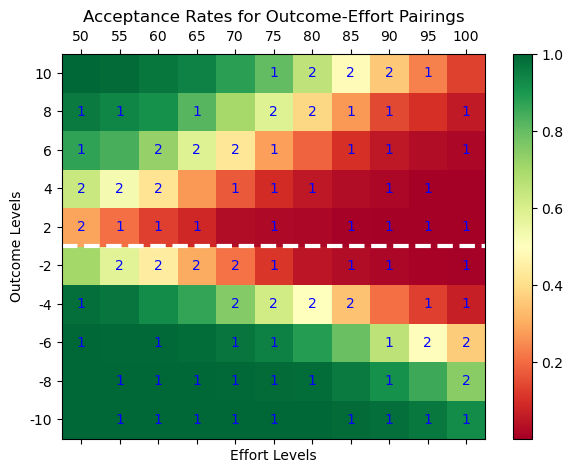

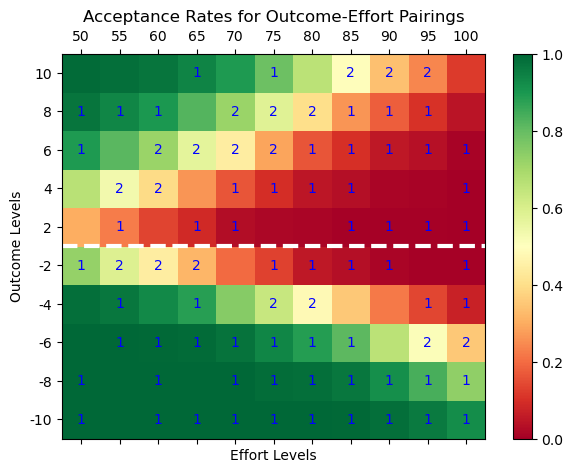

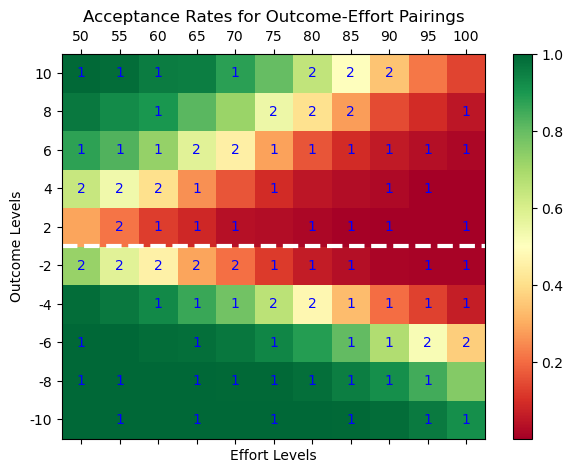

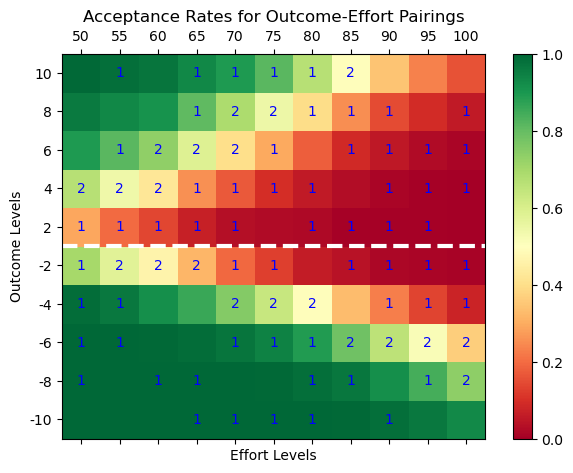

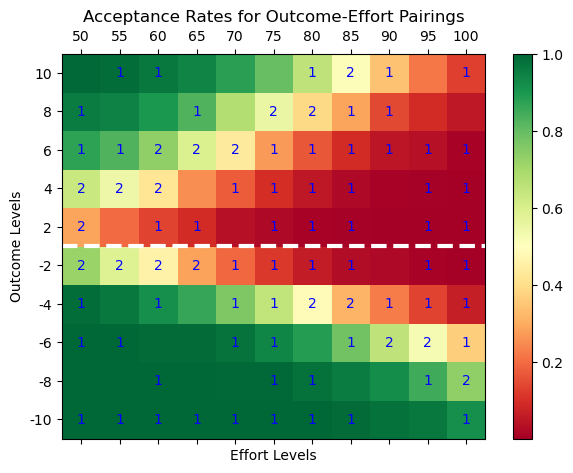

In [459]:
for i in range(5):

    # Generate stimuli and simulate responses
    stimuli = []  # List to store stimuli
    responses = []  # List to store responses

    for outcome in outcome_levels:
        for effort in effort_levels:
            # Calculate net values for all participants
            net_values = np.array([calculate_net_value(outcome, effort, alpha, k, lambda_)
                                for alpha, k, lambda_ in zip(alpha_values, k_values, lambda_values)])
            # Calculate acceptance probabilities using logistic function
            probabilities = logistic_choice_prob(net_values, decision_beta)
            # Simulate binary choices (accept/reject) based on probabilities
            choices = np.random.binomial(1, probabilities)
            # Store stimuli and responses
            stimuli.append((outcome, effort))
            responses.append(choices)

    # Convert responses to numpy array and calculate acceptance rates
    responses = np.array(responses)
    acceptance_rates = responses.mean(axis=1)

    # Reshape acceptance rates to create a matrix for outcome-effort pairings
    acceptance_matrix = acceptance_rates.reshape(len(outcome_levels), len(effort_levels))

    # Calculate sampling density inversely proportional to distance from 0.5 acceptance rate
    distance_from_05 = np.abs(acceptance_rates - 0.5)
    distance_from_05[distance_from_05 == 0] = 1e-6  # Avoid division by zero
    sampling_density = 1 / (distance_from_05) 

    # Create index pairs for positive and negative outcomes combined with all effort levels
    positive_outcomes_idx = np.where(outcome_levels > 0)[0]
    negative_outcomes_idx = np.where(outcome_levels < 0)[0]
    positive_pairs = [(i, j) for i in positive_outcomes_idx for j in range(len(effort_levels))]
    negative_pairs = [(i, j) for i in negative_outcomes_idx for j in range(len(effort_levels))]

    # Calculate sampling probabilities for positive and negative pairs based on sampling densities
    positive_sampling_density = np.array([sampling_density[i * len(effort_levels) + j] for i, j in positive_pairs])
    negative_sampling_density = np.array([sampling_density[i * len(effort_levels) + j] for i, j in negative_pairs])

    # Normalize sampling densities to get probabilities
    positive_sampling_prob = positive_sampling_density / positive_sampling_density.sum()
    negative_sampling_prob = negative_sampling_density / negative_sampling_density.sum()

    # Generate multiple schedules
    num_schedules = 100  # Number of schedules to generate
    # Generate a list of schedules by calling generate_schedule with different seeds
    schedules = [generate_schedule(seed) for seed in range(num_schedules)]

    # Evaluate all schedules and find the best one
    evaluation_scores = [evaluate_schedule(schedule) for schedule in schedules]  # Evaluate each schedule
    best_schedule_index = np.argmax(evaluation_scores)  # Find the index of the best schedule
    best_schedule = schedules[best_schedule_index]  # Select the best schedule based on the evaluation scores

    # Visualize the best schedule
    pair_counts = {}
    for pair in best_schedule:
        if pair in pair_counts:
            pair_counts[pair] += 1
        else:
            pair_counts[pair] = 1

    fig, ax = plt.subplots(figsize=(7, 5))
    cax = ax.matshow(acceptance_matrix, interpolation='nearest', cmap='RdYlGn')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(effort_levels)))
    ax.set_yticks(np.arange(len(outcome_levels)))
    ax.set_xticklabels((effort_levels*10).astype(int))
    ax.set_yticklabels(outcome_levels.astype(int))
    ax.invert_yaxis()
    lowest_reward_index = np.where(outcome_levels == min(abs(outcome_levels)))[0][0]
    ax.axhline(lowest_reward_index - 0.5, color='white', linestyle='--', linewidth=3)
    plt.xlabel('Effort Levels')
    plt.ylabel('Outcome Levels')
    plt.title('Acceptance Rates for Outcome-Effort Pairings')
    # Annotate selected pairs
    for (i, j), count in pair_counts.items():
        ax.text(j, i, str(count), va='center', ha='center', color='blue')
    plt.show()

